In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.backends.backend_pdf import PdfPages
from scipy import stats

import dpkt
import numpy as np
import time
import brewer2mpl

from AttackAnalysis import compute_effective_rate, compute_sending_rate
from analyze import compute_global_throughput, parse_file, removeOutliers
from read_conf import ReadHosts

# The nodes that don't have the updated kernel
* pc170, clientnode-3
* pc159, clientnode-11
* pc42, clientnode-7
* pc30, clientnode-14
* pc18, clientnode-13

Attackers:
* pc54	attacknode-6
* pc50	attacknode-5
* pc35	attacknode-2
* pc33	attacknode-1
* pc15	attacknode-3

In [35]:
host_to_ip, ip_to_host = ReadHosts('experiment_conf/experiment_oak_new.conf')
interval = 5
root_dir = 'workdir/results-smart-attacker/'
figures_dir = 'paper-plots/smart-attacker-exp1/'

In [3]:
linestyles = ['-', '--', '-.', ':']
markers = []
for m in Line2D.markers:
    try:
        if len(m) == 1 and m != ' ':
            markers.append(m)
    except TypeError:
        pass

styles = markers + [
    r'$\lambda$',
    r'$\bowtie$',
    r'$\circlearrowleft$',
    r'$\clubsuit$',
    r'$\checkmark$']

In [4]:
def get_througput_array (entry, interval_s):
    num_buckets = np.size(entry.inbytes)
    buckets = np.arange(0, num_buckets * interval_s, interval_s)

    bps = 10e-6 * entry.inbytes * 8 / interval_s
    
    return buckets, bps

In [5]:
def compute_everything(prefix='results-exp5_1_', capfile='servernode-log_agent-tcpdump.cap',
                       verbose=False, postfix=[''], shost='servernode'):
    throughput = {}
    for post in postfix:
        filename = root_dir + prefix + post
        print "Generating throughput for %s" % filename
        filename += '/' + capfile

        start_time = time.time()
        throughput[post] = compute_global_throughput(filename, interval, host_to_ip[shost])
        end_time = time.time()
        if verbose:
            print "Time taken is ", end_time - start_time
            
    return throughput

In [6]:
def plot_throughput_overimpose(in_throughput, in_host_to_ip, postfix=[], 
                               host=['clientnode-1'], yincr=[5,50], ylimincr=[5,50], 
                               plt_title=['Client','Server'], ystart=[-1,-10]):
    
    fig = plt.figure()#figsize=(10,10))
    k = 1
    
    for host_entry in host:
        host_ip = in_host_to_ip[host_entry]
        ax = fig.add_subplot(1,2,k)
        
        plotnum = 0
        for post in postfix:
            maxbps = 0
            
            th = in_throughput[post]
            host_th = th[host_ip]

            host_bucket, host_bps = get_througput_array (host_th, interval_s=interval)
            
            ax.plot(host_bucket, host_bps, marker=None, markerfacecolor='none', 
                    label=post, linewidth=2, color=colors[plotnum])
            plotnum += 1
            
        maxbps = np.maximum(maxbps, np.max(host_bps))

        plt.title(plt_title[k-1])
        ax.grid(axis='y', color="0.9", linestyle='-', linewidth=1)
        ax.set_ylim(ystart[k-1], maxbps+ylimincr[k-1])
        ax.set_xticks([0,100,200,300,400,500,600])
        ax.set_xlim(0,599)

        # set y ticks
        yrange = np.arange (0,maxbps+ylimincr[k-1],yincr[k-1])
        ax.set_yticks(yrange)

        #if k%2==0:
        #    ax.set_yticklabels([])  
        if not k%2==0:
            ax.set_ylabel('Throughput (Mbps)')
        
        ax.set_xlabel('Time (seconds)')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.tick_params(axis='x', direction='out')
        ax.tick_params(axis='y', length=0)
        ax.set_axisbelow(True)

        ax.axvspan(120,480,color='red', alpha=0.1)
        k += 1
        

    if len(fig.axes)%2 == 0:
        ax = fig.axes[-2]
    else:
        ax = fig.axes[-1]
    
    legend = ax.legend(loc = 9, ncol=5, bbox_to_anchor=(1.05, -0.2), borderaxespad=1.0)
    frame = legend.get_frame()
    frame.set_facecolor('1')
    frame.set_edgecolor('0.75')
 
    #plt.savefig('paper-plots/throughput-exp2-2.pdf', bbox_inches = 'tight')
    #plt.show()

In [7]:
def plot_next_to_each_other(in_throughput, in_host_to_ip, postfix=[], host='clientnode-1',
                            yincr=5, ylimincr=5, ystart=-1, coloridx=1):
    fig = plt.figure()
    plotnum = 1
    
    num_subplots = len(postfix)
    if num_subplots == 0:
        print "[ERROR:] Empty input postfix array!"
        return 
    
    host_ip = in_host_to_ip[host]
    
    # put three plots next to each other
    num_rows = num_subplots / 3
    if num_subplots % 3 > 0:
        num_rows += 1
    
    k = 0
    for post in postfix:
        maxbps = 0
    
        ax = fig.add_subplot(num_rows,3,plotnum)
        th = in_throughput[post]
        host_th = th[host_ip]

        host_bucket, host_bps = get_througput_array (host_th, interval_s=interval)

        ax.plot(host_bucket, host_bps, marker=None, markerfacecolor='none', 
                label=post, linewidth=2, color=colors[coloridx])
        plotnum += 1
            
        maxbps = np.maximum(maxbps, np.max(host_bps))

        ax.grid(axis='y', color="0.9", linestyle='-', linewidth=1)
        ax.set_ylim(ystart, maxbps+ylimincr)
        ax.set_xticks([0,100,200,300,400,500,600])
        ax.set_xlim(0,599)

        # set y ticks
        yrange = np.arange (0,maxbps+ylimincr,yincr)
        ax.set_yticks(yrange)

#         if k%3==0:
#             ax.set_yticklabels([])  
        if k%3==0:
            ax.set_ylabel('Throughput (Mbps)')
        
        ax.set_xlabel('Time (seconds)')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.tick_params(axis='x', direction='out')
        ax.tick_params(axis='y', length=0)
        ax.set_axisbelow(True)
        
        # draw the average line
        std_dev = np.std(host_bps[24:96])
        mean = np.mean(host_bps[25:96])
        ax.axhline(np.mean(host_bps[24:96]), linestyle='--', linewidth=1)
        high = mean+std_dev
        low = mean-std_dev
        ax.fill_between(np.arange(120,480,5), high, low, alpha=0.7, linewidth=0, color=colors[-1])
#         ax.axhline(mean+std_dev, linestyle='--', linewidth=1)
#         ax.axhline(mean-std_dev, linestyle='--', linewidth=1)

        #ax.axvspan(120,480,color='red', alpha=0.1)
        k += 1
        

#     if num_subplots%3 == 0:
#         ax = fig.axes[-3]
#     elif num_subplots%3 == 2:
#         ax = fig.axes[-2]
#     elif num_subplots%3 == 1:
#         ax = fig.axes[-1]
    
#     legend = ax.legend(loc = 9, ncol=5, bbox_to_anchor=(1.05, -0.2), borderaxespad=1.0)
#     frame = legend.get_frame()
#     frame.set_facecolor('1')
#     frame.set_edgecolor('0.75')

# Client throughput analysis

In [10]:
# change these for each section depending on your need
bmap = brewer2mpl.get_map('OrRd', 'Sequential', 3)
colors = bmap.mpl_colors

params = {
   'axes.labelsize': 9,
   'text.fontsize': 10,
   'legend.fontsize': 9,
   'legend.handlelength': 2,
   'xtick.labelsize': 8,
   'ytick.labelsize': 8,
   'text.usetex': False,
   'figure.figsize': [9, 3]
   }
plt.rcParams.update(params)

In [12]:
throughput = compute_everything(prefix='', postfix=['results-smart-attacker'], verbose=True)

Generating throughput for workdir/results-smart-attacker/results-smart-attacker
Time to read pcap file 0.000524997711182
Time taken is  106.547811031


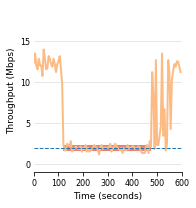

In [33]:
plot_next_to_each_other(throughput, host_to_ip, postfix=['results-smart-attacker'], host='clientnode-1',
                            yincr=5, ylimincr=5, ystart=-1, coloridx=1)

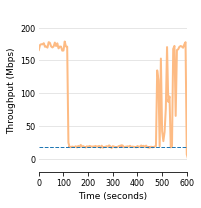

In [34]:
plot_next_to_each_other(throughput, host_to_ip, postfix=['results-smart-attacker'], host='servernode',
                            yincr=50, ylimincr=50, ystart=-20, coloridx=1)